In [1]:
%matplotlib inline
import numpy as np
import scipy.optimize as optimization
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib
import arviz as az
import theano
import ODE_models_forls
import pandas as pd
import scipy.integrate as integrate
from scipy.integrate import quad
plt.style.use('seaborn-darkgrid')

In [2]:
#Read Data Files
r_newyorkTSV = '../../newyork.tsv'
w_newyorkTSV = '../../newyork.tsv'
tsv_readny = pd.read_csv("newyork.tsv", sep='\t')
cumulativeny = tsv_readny['confirmed'] #is this what I want?

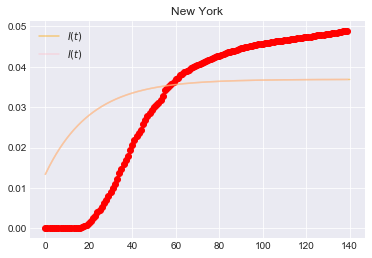

In [3]:
#Plot the data and the model output
params = ODE_models_forls.get_params(beta_S=0.10190424, beta_A= 0.17231283,q=0.57370648, nu = 0.05461374, m =0.19812869, rho=11.35080311, mu = 0.89205848)
## Set initial conditions
Nny= 8.399e6
yobsny = cumulativeny/Nny
#Sn_0ny  = 1-(0.005+yobsny[0])
#Sa_0  = 0.005
#IS_0ny  = yobsny[0]

Sa_0  =  0.97532945
IS_0ny  = 0.0133901
Sn_0ny = 1-(Sa_0+IS_0ny)
IAn_0 = 0
IAa_0 = 0
RS_0  = 0
RAn_0 = 0
RAa_0 = 0
M_0   = 0.01

#newyork
initial_stateny = np.array([Sn_0ny,Sa_0,IS_0ny,IAn_0,IAa_0,RS_0,RAn_0,RAa_0,M_0])
timeny = np.arange(0,140,.001)
timeobsny = np.arange(0,140,1)
sim_systemny = odeint(ODE_models_forls.SIRan_system, initial_stateny, timeny, args=(params,))



yny =1-(sim_systemny[:,0]+sim_systemny[:,1])

ypred = np.zeros(140)
for i in range(0,140):
    ind = np.where(timeny ==i)
    ypred[i] = yny[ind]


plt.plot(timeobsny,yobsny, color= 'red',marker='o', linestyle='none')
plt.plot(timeny, yny, color='orange', alpha=0.5, label=f'$I(t)$')
plt.plot(timeobsny, ypred, color='pink', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.title('New York')
plt.show()

In [4]:
#This is where the least squares is claculated for New York
def SEfunc(params):
    #SEfunc is a function that takes the parameters of the ODE models as an input and outputs the least squares value for the function at that time
    #What I need is a fucntion that computes the least squares at the starting points for the values? I.e. if the function
    #remained at those initial guesses
    beta_S=params[0]
    beta_A = params[1]
    q= params[2]
    nu=params[3]
    m = params[4]
    rho = params[5]
    mu = params[6]
    Sa_0 = params[7]
    IS_0ny= params[8]
    yobsny = np.array(cumulativeny/Nny)
    Sn_0ny = 1-(Sa_0+IS_0ny)
    IAn_0 = 0
    IAa_0 = 0
    RS_0  = 0
    RAn_0 = 0
    RAa_0 = 0
    M_0   = 0.01
    
    
    se_params = ODE_models_forls.get_params(beta_S=beta_S, beta_A= beta_A, q = q,nu = nu, m=m,rho=rho,mu=mu)

   
    initial_stateny = np.array([Sn_0ny,Sa_0,IS_0ny,IAn_0,IAa_0,RS_0,RAn_0,RAa_0,M_0])
    timeny = np.arange(0,140,.001)
    timeobsny = np.arange(0,140,1)
    sim_systemny = odeint(ODE_models_forls.SIRan_system, initial_stateny, timeny, args=(se_params,))
    yny =1-(sim_systemny[:,0]+sim_systemny[:,1])
    
    ypred = np.zeros(140)
    for i in range(0,140):
        ind = np.where(timeny ==i)
        ypred[i] = yny[ind]
    
    SE = (ypred-yobsny)**2
    sumSE = sum(SE)
    return(sumSE)




In [5]:
import random as random
sims = int(1e2)
values = np.zeros((10,sims))
for i in range(0,sims):
    starting_points = np.zeros(9) #Beta_s, beta_a, q, nu, m, rho, mu, S-a(0), I_s(0)
    starting_points[0] = np.random.uniform(0,1)
    starting_points[1] = np.random.uniform(0,1)
    starting_points[2] = np.random.uniform(0,1)
    starting_points[3] = np.random.uniform(0,1)
    starting_points[4] = np.random.uniform(0,1)
    starting_points[5] = np.random.uniform(0,100)
    starting_points[6] = np.random.uniform(0,1)
    starting_points[7] = np.random.uniform(0,1)
    starting_points[8] = np.random.uniform(0,1)
    least_sq = SEfunc(starting_points)
    values[0:8,i] = starting_points[0:8]
    values[9,i] = least_sq
    
    
    


/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [6]:
least = list(values[9])
x=min(least)
minimum = least.index(x)
print(minimum)
print(values[:,minimum])
x0_ = values[:,minimum]

83
[1.86870120e-02 7.20761753e-01 5.60918970e-01 6.28272564e-01
 1.91693020e-02 2.78457410e+01 5.55025026e-01 6.70104448e-01
 0.00000000e+00 3.67479359e+00]


Starting values to run the least squares code on should be: 
$$\beta_S = 0.2351789$$
$$\beta_A = 0.46373967$$
$$q =  0.36396384  $$
$$nu =  0.4011308 $$
$$m = 0.98983561$$
$$rho = 42.34312919$$
$$mu = 0.97572124$$
$$Sa_0 =  0.17790549$$
$$Is_0 = 0$$




In [7]:
x0=x0_[:9]

result= optimization.least_squares(SEfunc, x0,bounds=(np.zeros(9),np.array([1,1,1,1,1,np.inf,1,1,1])))

In [8]:
print(result)

 active_mask: array([0, 0, 0, 0, 0, 0, 0, 0, 0])
        cost: 0.0032376281076607343
         fun: array([0.08046898])
        grad: array([ 0.1054739 ,  0.04189667, -0.1921331 , -0.00179916, -0.00315643,
       -0.00773267, -0.0105663 , -0.00281033, -0.0585427 ])
         jac: array([[ 1.31073986,  0.5206562 , -2.38766669, -0.0223584 , -0.03922545,
        -0.09609498, -0.13130905, -0.03492437, -0.72751889]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 20
        njev: 7
  optimality: 0.08436059027319306
      status: 3
     success: True
           x: array([1.87124280e-02, 7.20758158e-01, 5.60926293e-01, 6.28282811e-01,
       1.92060122e-02, 2.77309383e+01, 5.55013385e-01, 6.70118116e-01,
       4.79913112e-04])


In [9]:
print(sim_systemny[:,0])

[0.01128045 0.02112026 0.03086653 ... 0.60411137 0.60411137 0.60411136]
